In [ ]:

import puma
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from ftag import Cuts
from ftag.hdf5 import H5Reader



In [6]:
reader = H5Reader('/eos/home-a/anmilici/ntupla.h5', batch_size=10000)
data = reader.load({"jets": ["pt", "eta","PartonTruthLabelID",
                             "HadronConeExclTruthLabelID",
                             "HadronConeExclTruthLabelPdgId",
                             "n_tracks","eventNumber"],
                    "tracks":["pt","qOverP","ftagTruthSourceLabel",
                              "ftagTruthOriginLabel",
                              "ftagTruthTypeLabel",
                              "ftagTruthSourceLabel",
                              "ftagTruthVertexIndex",
                              "GN2v01_aux_TrackOrigin",
                              "GN2v01_aux_VertexIndex",
                              "valid"]}, num_jets=500000)


In [7]:
flavour_cuts = Cuts.from_list([("PartonTruthLabelID", "==", 5),("HadronConeExclTruthLabelID","==",5)])
#in this way i select jets tagged with bjets at parton level and which contain at least a bhadron (shall i use HadronConeExtendedExclTruthLabelID ?)

idx,bjets=flavour_cuts(data["jets"])
tracks=data["tracks"][idx]

print("nbjets=",len(bjets))
print("ntracks=",len(tracks))

nbjets= 184306
ntracks= 184306


In [11]:
#neutral bhadrons from all the possible values of HadronConeExclTruthLabelPdgId

#neutral_bhadrons_list=[511,531,551,553,555,5122,5232,-511,-531,-551,-553,-555,-5122,-5232]

removed_bhadrons_list=[0,-0,541,   531,   511,   551,   553,   555,  5122,  5132,
        5232,  5332,   431,   421,   411,   441,   443,   445,  4122,
        4132,  4232,  4332,  4322,    15,  -541,  -531,  -511,
        -551,  -553,  -555, -5122, -5132, -5232, -5332,  -431,  -421,
        -411,  -441,  -443,  -445, -4122, -4132, -4232, -4332, -4322,
         -15]
#charged bhadrons are what it remains

charged_Bmesons_cut=Cuts.from_list([("HadronConeExclTruthLabelPdgId","!=",x) for x in removed_bhadrons_list])
index,charged_bjets=charged_Bmesons_cut(bjets)
charged_tracks=tracks[index]

Bplus_cut=Cuts.from_list([("HadronConeExclTruthLabelPdgId","==",521)])
Bplus=Bplus_cut(charged_bjets).values

Bminus_cut=Cuts.from_list([("HadronConeExclTruthLabelPdgId","==",-521)])
Bminus=Bminus_cut(charged_bjets).values

#total number of jet with a charged B hadron we are looking at

ncharged=len(charged_bjets)

npos=len(Bplus)
nneg=len(Bminus)

assert all(np.isin(charged_bjets["HadronConeExclTruthLabelPdgId"], [521, -521])), "There are jets with HadronConeExclTruthLabelPdgId other than 521 and -521 in charged_bjets"
print("number of charged bjet=",ncharged)
print("truth positive=",npos)
print("truth negative=",nneg)

number of charged bjet= 79116
truth positive= 39502
truth negative= 39614


In [12]:
def charge_algorithm(index,tracks,
                     mode:str):
  string=' '

  if mode=="GN2":
    string='GN2v01_aux_TrackOrigin'
  elif mode=='truth':
    string='ftagTruthOriginLabel'

  #cutting on all the tracks that has not ftagTruthOriginLabel == 3(fromB) or 4(fromBC)

  truth_fromB_BC_cuts=Cuts.from_list([(string,"!=",0),
                                      (string,"!=",1),
                                      (string,"!=",2),
                                      (string,"!=",5),
                                      (string,"!=",6),
                                      (string,"!=",7),
                                      ("valid","==",True)])

  secondaries=truth_fromB_BC_cuts(tracks).values
  charge=np.sign(secondaries["qOverP"]).sum()
  return charge

 

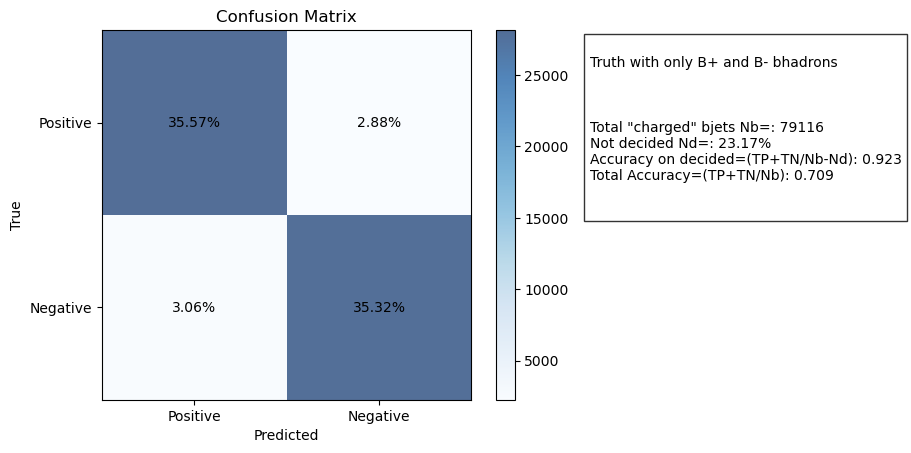

In [15]:
confusion_matrix=np.zeros((2,2))
debug=False
not_decided=0
residuals=[]

for i,jet in enumerate(charged_bjets):

  charge=charge_algorithm(i,charged_tracks[i],'truth')

  # taking the residuals absolute value
  residuals.append(np.abs(np.sign(jet["HadronConeExclTruthLabelPdgId"])-np.sign(charge)))

  if jet["HadronConeExclTruthLabelPdgId"]>0:
    if charge>0:
      confusion_matrix[0,0]+=1
    elif charge<0:
      confusion_matrix[0,1]+=1

  elif jet["HadronConeExclTruthLabelPdgId"]<0:
    if charge>0:
      confusion_matrix[1,0]+=1
    elif charge<0:
      confusion_matrix[1,1]+=1

  #this is the case where the sum of the tracks is zero, we count these events in not_decided
  if charge==0:
    not_decided+=1

  if debug==True:
    print("bhadron=",jet["HadronConeExclTruthLabelPdgId"])
    print("charge SUM=",charge)
    print("\n")
    if i>200:
        break

# just plotting the confusion matrix

plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest',alpha=0.7)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
for i in range(confusion_matrix.shape[0]):  # righe
    for j in range(confusion_matrix.shape[1]):  # colonne
        plt.text(j, i, "{}%".format(round(100*confusion_matrix[i, j]/ncharged,2)),
                 ha='center', va='center', color='black')



text_box = f"""
Truth with only B+ and B- bhadrons\n
\n
Total "charged" bjets Nb=: {ncharged}
Not decided Nd=: {round(100*not_decided/ncharged,2)}%
Accuracy on decided=(TP+TN/Nb-Nd): {((confusion_matrix[0,0]+confusion_matrix[1,1])/(len(charged_bjets)-not_decided)).round(3)}
Total Accuracy=(TP+TN/Nb): {((confusion_matrix[0, 0] + confusion_matrix[1, 1]) / len(charged_bjets)).round(3)}

"""
text=plt.gcf().text(0.93, 0.5, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))


plt.savefig('TRUTH_with_OtherSec.png', dpi=300, bbox_inches='tight')









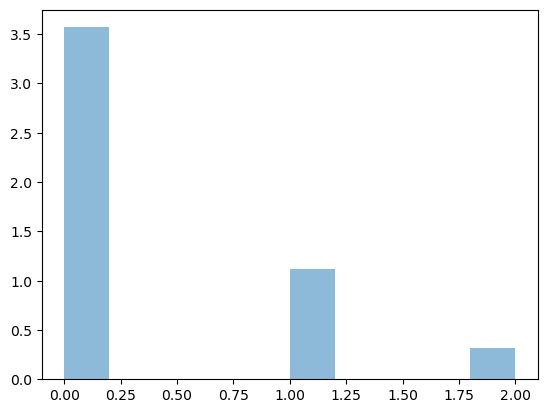

In [ ]:
hist=plt.hist(residuals,alpha=0.5,density=True)
plt.show()


# GN2 prediction

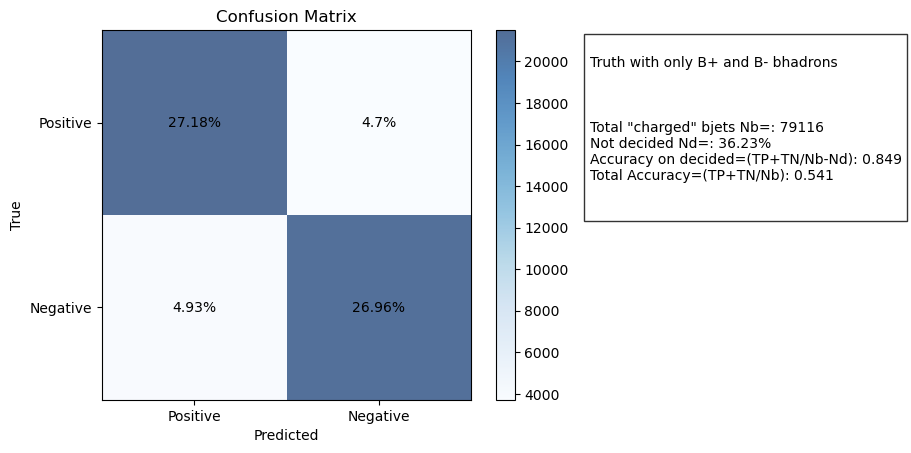

In [ ]:
confusion_matrix=np.zeros((2,2))
debug=False
not_decided=0
residuals=[]

for i,jet in enumerate(charged_bjets):

  charge=charge_algorithm(i,charged_tracks[i],'GN2')

  # taking the residuals absolute value
  residuals.append(np.abs(np.sign(jet["HadronConeExclTruthLabelPdgId"])-np.sign(charge)))

  if jet["HadronConeExclTruthLabelPdgId"]>0:
    if charge>0:
      confusion_matrix[0,0]+=1
    elif charge<0:
      confusion_matrix[0,1]+=1

  elif jet["HadronConeExclTruthLabelPdgId"]<0:
    if charge>0:
      confusion_matrix[1,0]+=1
    elif charge<0:
      confusion_matrix[1,1]+=1

  #this is the case where the sum of the tracks is zero, we count these events in not_decided
  if charge==0:
    not_decided+=1

  if debug==True:
    print("bhadron=",jet["HadronConeExclTruthLabelPdgId"])
    print("charge SUM=",charge)
    print("\n")
    if i>200:
        break

# just plotting the confusion matrix

plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest',alpha=0.7)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
for i in range(confusion_matrix.shape[0]):  # righe
    for j in range(confusion_matrix.shape[1]):  # colonne
        plt.text(j, i, "{}%".format(round(100*confusion_matrix[i, j]/ncharged,2)),
                 ha='center', va='center', color='black')



text_box = f"""
GN2 with only B+ and B- bhadrons\n
\n
Total "charged" bjets Nb=: {ncharged}
Not decided Nd=: {round(100*not_decided/ncharged,2)}%
Accuracy on decided=(TP+TN/Nb-Nd): {((confusion_matrix[0,0]+confusion_matrix[1,1])/(len(charged_bjets)-not_decided)).round(3)}
Total Accuracy=(TP+TN/Nb): {((confusion_matrix[0, 0] + confusion_matrix[1, 1]) / len(charged_bjets)).round(3)}

"""
text=plt.gcf().text(0.93, 0.5, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))


plt.savefig('TRUTH_with_OtherSec.png', dpi=300, bbox_inches='tight')









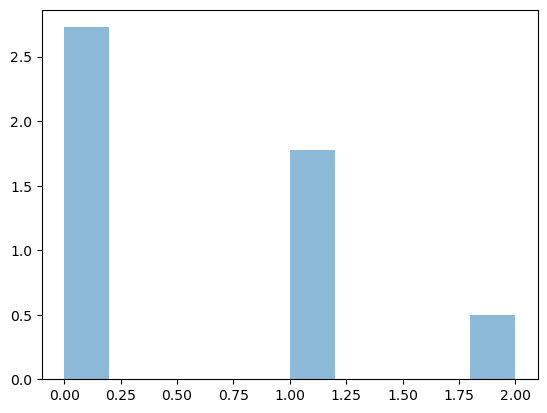

In [ ]:
hist=plt.hist(residuals,alpha=0.5,density=True)
plt.show()
